## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818,0
1,1,2019-02-24,52.839273,179.611525,1.979019,11.066667,75.883806,0.000000,-0.276422,-1.255324,0.062222,1907.347412,27.922180,0
2,2,2019-01-27,56.642593,66.362963,3.916667,12.466667,73.714815,0.000000,2.674324,2.326601,1.582222,301.056529,227.954035,0
3,3,2019-02-17,49.299471,267.369841,5.489524,14.066667,67.711164,0.000778,-4.882030,-0.070813,1.528889,14.666560,13.316158,0
4,4,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0


In [4]:
scores_df.head()

,Unnamed: 0,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61.0,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60.0,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55.0,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59.0,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53.0,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'Unnamed: 0')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58.0,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [9]:
len(all_df)

2960

In [53]:
lc_df = all_df[(all_df['Name'] == 'Luiz Celeste') & (all_df['course_id'] == 0)]
lc_df

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
1575,Luiz Celeste,56.0,0.00,56.00,2018-11-04 07:30:00,0,2018-11-04,57.998329,233.283598,2.701309,12.000000,82.412754,0.000768,-2.212663,-1.189524,9.066667,168.930299,595.295093
1680,Luiz Celeste,56.0,0.00,56.00,2018-11-11 07:30:00,0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212
1887,Luiz Celeste,60.0,8.96,68.96,2018-11-25 07:30:00,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818
1996,Luiz Celeste,54.0,0.83,54.83,2018-12-02 07:30:00,0,2018-12-02,51.962407,74.183519,1.531852,10.066667,66.050370,0.000000,0.973358,0.952229,7.128889,346.478558,1050.367545
2107,Luiz Celeste,56.0,1.92,57.92,2018-12-09 07:30:00,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702
2249,Luiz Celeste,54.0,3.55,57.55,2018-12-16 07:30:00,0,2018-12-16,59.633333,130.906614,4.069841,19.533333,81.322751,0.000000,2.057238,-2.256748,13.182222,270.720132,2851.553387
2335,Luiz Celeste,57.0,5.56,62.56,2018-12-23 07:30:00,0,2018-12-23,55.744082,92.798551,0.226570,4.200000,78.270169,0.000000,0.191350,0.049464,3.093333,452.046201,544.567717
2425,Luiz Celeste,56.0,-0.45,55.55,2018-12-30 07:30:00,0,2018-12-30,50.780123,104.042487,1.036966,8.000000,81.401499,0.000000,0.283379,0.465501,0.000000,3660.778308,0.000000
2532,Luiz Celeste,50.0,-3.13,46.87,2019-01-13 07:30:00,0,2019-01-13,54.356944,68.790278,4.691667,14.600000,79.706944,0.000389,4.087325,1.565524,6.240000,26.691578,144.098932
2663,Luiz Celeste,55.0,1.32,56.32,2019-01-20 07:30:00,0,2019-01-20,56.668056,228.171868,3.617849,16.400000,96.696247,0.012111,-2.490328,-2.198933,2.240000,19.627782,10.794536


In [54]:
lc_df = lc_df.reset_index()
lc_df = lc_df.drop(columns = 'index')
lc_df

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Luiz Celeste,56.0,0.00,56.00,2018-11-04 07:30:00,0,2018-11-04,57.998329,233.283598,2.701309,12.000000,82.412754,0.000768,-2.212663,-1.189524,9.066667,168.930299,595.295093
1,Luiz Celeste,56.0,0.00,56.00,2018-11-11 07:30:00,0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212
2,Luiz Celeste,60.0,8.96,68.96,2018-11-25 07:30:00,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818
3,Luiz Celeste,54.0,0.83,54.83,2018-12-02 07:30:00,0,2018-12-02,51.962407,74.183519,1.531852,10.066667,66.050370,0.000000,0.973358,0.952229,7.128889,346.478558,1050.367545
4,Luiz Celeste,56.0,1.92,57.92,2018-12-09 07:30:00,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702
5,Luiz Celeste,54.0,3.55,57.55,2018-12-16 07:30:00,0,2018-12-16,59.633333,130.906614,4.069841,19.533333,81.322751,0.000000,2.057238,-2.256748,13.182222,270.720132,2851.553387
6,Luiz Celeste,57.0,5.56,62.56,2018-12-23 07:30:00,0,2018-12-23,55.744082,92.798551,0.226570,4.200000,78.270169,0.000000,0.191350,0.049464,3.093333,452.046201,544.567717
7,Luiz Celeste,56.0,-0.45,55.55,2018-12-30 07:30:00,0,2018-12-30,50.780123,104.042487,1.036966,8.000000,81.401499,0.000000,0.283379,0.465501,0.000000,3660.778308,0.000000
8,Luiz Celeste,50.0,-3.13,46.87,2019-01-13 07:30:00,0,2019-01-13,54.356944,68.790278,4.691667,14.600000,79.706944,0.000389,4.087325,1.565524,6.240000,26.691578,144.098932
9,Luiz Celeste,55.0,1.32,56.32,2019-01-20 07:30:00,0,2019-01-20,56.668056,228.171868,3.617849,16.400000,96.696247,0.012111,-2.490328,-2.198933,2.240000,19.627782,10.794536


In [57]:
lc_df = lc_df.reset_index()
lc_df

,index,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,0,Luiz Celeste,56.0,0.00,56.00,2018-11-04 07:30:00,0,2018-11-04,57.998329,233.283598,2.701309,12.000000,82.412754,0.000768,-2.212663,-1.189524,9.066667,168.930299,595.295093
1,1,Luiz Celeste,56.0,0.00,56.00,2018-11-11 07:30:00,0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212
2,2,Luiz Celeste,60.0,8.96,68.96,2018-11-25 07:30:00,0,2018-11-25,57.023188,80.344928,1.289855,6.800000,88.214493,0.000000,0.807230,0.670447,0.560000,266.490351,154.904818
3,3,Luiz Celeste,54.0,0.83,54.83,2018-12-02 07:30:00,0,2018-12-02,51.962407,74.183519,1.531852,10.066667,66.050370,0.000000,0.973358,0.952229,7.128889,346.478558,1050.367545
4,4,Luiz Celeste,56.0,1.92,57.92,2018-12-09 07:30:00,0,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702
5,5,Luiz Celeste,54.0,3.55,57.55,2018-12-16 07:30:00,0,2018-12-16,59.633333,130.906614,4.069841,19.533333,81.322751,0.000000,2.057238,-2.256748,13.182222,270.720132,2851.553387
6,6,Luiz Celeste,57.0,5.56,62.56,2018-12-23 07:30:00,0,2018-12-23,55.744082,92.798551,0.226570,4.200000,78.270169,0.000000,0.191350,0.049464,3.093333,452.046201,544.567717
7,7,Luiz Celeste,56.0,-0.45,55.55,2018-12-30 07:30:00,0,2018-12-30,50.780123,104.042487,1.036966,8.000000,81.401499,0.000000,0.283379,0.465501,0.000000,3660.778308,0.000000
8,8,Luiz Celeste,50.0,-3.13,46.87,2019-01-13 07:30:00,0,2019-01-13,54.356944,68.790278,4.691667,14.600000,79.706944,0.000389,4.087325,1.565524,6.240000,26.691578,144.098932
9,9,Luiz Celeste,55.0,1.32,56.32,2019-01-20 07:30:00,0,2019-01-20,56.668056,228.171868,3.617849,16.400000,96.696247,0.012111,-2.490328,-2.198933,2.240000,19.627782,10.794536


In [58]:
lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 4, random_state=42)

In [59]:
X = lc_df[['index','weighted_T','weighted_w_dir','weighted_w_spd','weighted_w_gust','weighted_rh',
           'weighted_precip','weighted_w_u','weighted_w_v','w_gust_var','w_dir_var','w_uv_var']].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [60]:
X_scaled.shape

(16, 12)

In [61]:
y = lc_df.Raw.values

In [62]:
lr.fit(X_scaled,y)

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013809668828333344, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016729834547962952, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020079243513515088, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase t

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03853048624154454, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04374164519263424, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048943958617492456, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15251332459676492, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15058410804298794, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14818996611120383, tolerance: 0.012625
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the 

ElasticNetCV(alphas=None, copy_X=True, cv=4, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=42,
             selection='cyclic', tol=0.0001, verbose=0)

In [63]:
lr.score(X_scaled,y)

0.21084494009884902

In [64]:
lr.intercept_

56.3125

In [65]:
y.shape

(16,)

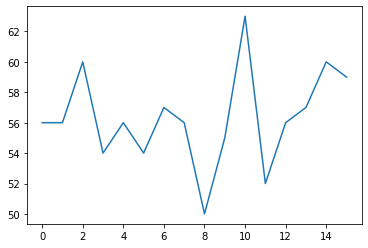

In [66]:
plt.plot(y)

In [67]:
lr.coef_

array([ 0.        ,  0.        , -0.        , -0.        , -0.09752751,
        0.        ,  0.        ,  0.        ,  0.        , -0.6688716 ,
       -0.        ,  0.        ])

In [68]:
lr2 = LinearRegression()
lr2.fit(X,y)
lr2.score(X,y)

0.739321527181622

In [69]:
lr2.coef_

array([ 2.47553136e-02,  3.56646249e-01,  2.97814554e-02,  8.42511251e-01,
       -3.88719026e-01,  9.63865666e-02, -3.09204144e+02,  2.19549027e-01,
        7.83184118e-01, -1.28296376e+00, -6.73656665e-04,  4.79687614e-03])

In [70]:
lr2.intercept_

30.821378390057824

In [71]:
yp = lr.predict(X_scaled)

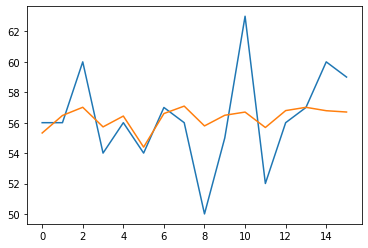

In [72]:
plt.plot(y)
plt.plot(yp)

In [52]:
lr.l1_ratio_, lr.alpha_

(0.1, 0.9520031432582587)

In [57]:
lr3.fit(X_scaled, y)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [58]:
lr3.coef_

array([-0.03123215,  0.7484978 , -0.6254135 ])

In [59]:
lr3.score(X_scaled, y)

0.07877806259635756

In [60]:
lr.alpha_

4.2989547206261856

In [61]:
lr.l1_ratio_

0.1

In [62]:
scores = cross_val_score(lr2, X_scaled, y, cv=4)
scores.mean()

-2.671216858418495

In [73]:
medians_df = all_df.groupby(['date','course_id']).median()
medians_df.head()

,,Raw,Handicap,Adjusted,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
date,course_id,,,,,,,,,,,,,,
2017-01-28,2,55.0,NaN,NaN,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
2017-02-25,2,61.0,NaN,NaN,51.399839,263.967874,1.268378,8.522222,65.060386,0.0,-1.164293,-0.069125,6.541728,325.376581,3147.061947
2017-03-04,2,59.0,NaN,NaN,56.731804,232.679348,3.031703,13.555556,79.230878,0.0,-2.292356,-1.620543,7.580247,97.945420,794.335555
2017-03-11,2,54.5,NaN,NaN,59.544827,261.774084,1.446659,7.333333,78.897746,0.0,-1.314740,-0.188172,0.888889,51.448579,14.484572
2017-03-15,2,55.0,NaN,NaN,57.350670,223.882933,2.000793,11.666667,83.171862,0.0,-1.059021,-0.828380,3.555556,38.044940,50.040828


In [74]:
mX = medians_df[['weighted_T','weighted_w_dir','weighted_w_spd','weighted_w_gust','weighted_rh','weighted_precip',
                'weighted_w_u','weighted_w_v','w_gust_var','w_dir_var','w_uv_var']].values
mscaler = StandardScaler().fit(mX)
mX_scaled = mscaler.transform(mX)
my = medians_df.Raw.values

In [75]:
lr4 = LinearRegression()
lr4.fit(mX_scaled, my)
lr4.score(mX_scaled, my)

0.3236009706605153

In [76]:
lr5 = ElasticNetCV(l1_ratio = [.1, .3, .5, .7, .9, .95], cv=4, random_state = 42)
lr5.fit(mX_scaled, my)
lr5.score(mX_scaled, my)

0.2965009135290445

In [77]:
lr5.coef_

array([-0.55291467, -0.22552201,  0.4365023 ,  0.40831475, -0.51570422,
        0.44888612, -0.21258862, -0.1403659 ,  0.21286534,  0.17288724,
        0.        ])

In [78]:
mX2 = medians_df[['weighted_w_gust','weighted_precip']].values
mscaler = StandardScaler().fit(mX2)
mX2_scaled = mscaler.transform(mX2)
my = medians_df.Raw.values

In [79]:
lr6 = ElasticNetCV(l1_ratio = [.1, .3, .5, .7, .9, .95], cv=4, random_state = 42)
lr6.fit(mX2_scaled, my)
lr6.score(mX2_scaled, my)

0.18042860473666644

In [80]:
lr5.alpha_

0.2825848445510033

In [81]:
lr6.alpha_

0.049382504126463486

In [82]:
lr5.l1_ratio_

0.1

In [83]:
lr6.l1_ratio_

0.1

In [84]:
cross_val_score(lr6, mX2_scaled, my, cv=4)

array([-0.03097665,  0.13520141,  0.28608684,  0.03032267])

In [86]:
myp = lr5.predict(mX_scaled)

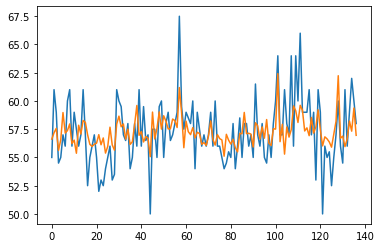

In [87]:
plt.plot(my)
plt.plot(myp)

In [134]:
medians_filled_df = medians_df.fillna('0')
medians_filled_df.head()

,,Raw,Handicap,Adjusted,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
date,course_id,,,,,,,,,,,,,
2017-03-15,2,55.0,0,0,13.402778,0.000000,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
2017-03-22,2,57.0,0,0,21.395833,0.110486,57.452083,207.297222,4.037500,0.0,62.796528,0.0,-1.970993,0.323788
2017-03-29,2,56.0,0,0,10.708333,0.000000,60.177083,162.647917,2.062500,0.0,61.956250,0.0,-0.102262,-1.215809
2017-04-05,2,60.0,0,0,6.243056,0.000000,62.146528,156.870139,1.201389,0.0,31.572917,0.0,0.616294,-0.197730
2017-04-12,2,61.0,0,0,0.472222,0.106250,62.077083,207.600000,0.097917,0.0,61.248611,0.0,-0.051002,-0.081538


In [141]:
mX3 = medians_filled_df[['Handicap','weighted_w_spd','weighted_precip']].values
m3scaler = StandardScaler().fit(mX3)
mX3_scaled = m3scaler.transform(mX3)
my3 = medians_filled_df.Raw.values

In [142]:
lr7 = ElasticNetCV(l1_ratio = [.05, .1, .2, .3, .5, .7, .9, .95, .99], cv=5, random_state = 42)

In [143]:
lr7.fit(mX3_scaled, my3)
lr7.score(mX3_scaled, my3)

0.09660561409211721

In [144]:
my3p = lr7.predict(mX3_scaled)

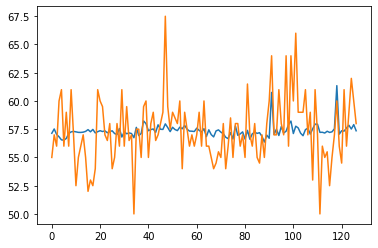

In [145]:
plt.plot(my3p)
plt.plot(my3)

In [88]:
medians_df.sort_values('Raw', ascending=False).head(5)

,,Raw,Handicap,Adjusted,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
date,course_id,,,,,,,,,,,,,,
2018-05-30,2,67.5,NaN,NaN,58.010278,223.325000,9.550000,26.200000,76.766667,0.000000,-6.846100,-3.879951,1.493333,258.763935,35.018206
2019-02-16,2,66.0,NaN,NaN,51.154885,285.672751,5.109347,17.111111,77.702734,0.017372,-4.463798,1.724377,16.320988,131.610303,250.577239
2019-01-27,0,64.0,1.295,64.620,56.642593,66.362963,3.916667,12.466667,73.714815,0.000000,2.674324,2.326601,1.582222,301.056529,227.954035
2019-02-09,2,64.0,NaN,NaN,50.181790,167.006173,3.425926,12.111111,84.033951,0.031420,1.017863,-2.803573,7.209877,375.851642,3963.394724
2019-01-06,0,64.0,-0.035,63.965,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313
